# Spam Detection Project Reproduced One-to-One

In [ ]:
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import patsy
from statsmodels.discrete.discrete_model import ProbitResults, LogitResults
from scipy.stats import chi2
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.preprocessing import MinMaxScaler

Import the dataset:

In [1]:
spam = pd.read_csv("C:/Users/justy/Desktop/Info/Inne/DSC/UW/Semestr IV/RR/RR_Project/Initial research/spambase - raw data/spambase.data", header=None)
names = pd.read_csv("names.csv", header=None)

NameError: name 'pd' is not defined

In [43]:
spam.describe

<bound method NDFrame.describe of         0     1     2    3     4     5     6     7     8     9   ...     48  \
0     0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
1     0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.000   
2     0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.010   
3     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
4     0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.000   
...    ...   ...   ...  ...   ...   ...   ...   ...   ...   ...  ...    ...   
4596  0.31  0.00  0.62  0.0  0.00  0.31  0.00  0.00  0.00  0.00  ...  0.000   
4597  0.00  0.00  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4598  0.30  0.00  0.30  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.102   
4599  0.96  0.00  0.00  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.000   
4600  0.00  0.00  0.65  0.0  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.000   

         49   50 

In [44]:
names.describe

<bound method NDFrame.describe of                              0
0               word_freq_make
1            word_freq_address
2                word_freq_all
3                 word_freq_3d
4                word_freq_our
5               word_freq_over
6             word_freq_remove
7           word_freq_internet
8              word_freq_order
9               word_freq_mail
10           word_freq_receive
11              word_freq_will
12            word_freq_people
13            word_freq_report
14         word_freq_addresses
15              word_freq_free
16          word_freq_business
17             word_freq_email
18               word_freq_you
19            word_freq_credit
20              word_freq_your
21              word_freq_font
22               word_freq_000
23             word_freq_money
24                word_freq_hp
25               word_freq_hpl
26            word_freq_george
27               word_freq_650
28               word_freq_lab
29              word_freq_labs
30   

In [45]:
#rename columns

names.loc[48, 0] = "char_freq_semicolon"
names.loc[49, 0] = "char_freq_bracket"
names.loc[50, 0] = "char_freq_square_bracket"
names.loc[51, 0] = "char_freq_exclamation"
names.loc[52, 0] = "char_freq_dollar"
names.loc[53, 0] = "char_freq_hashtag"
names.loc[57, 0] = "spam"

In [46]:
#remove missing values

spam.columns = names[0].values

spam.dropna(inplace=True)

In [47]:
#overview of our database

spam.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


Let us check the distribution of spam and non-spam mails

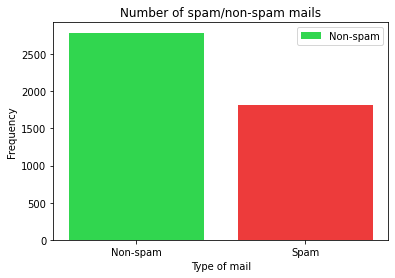

In [48]:
spam_count = spam["spam"].value_counts()
perc_yes = round(spam_count[1] / len(spam) * 100, 2)
perc_no = round(spam_count[0] / len(spam) * 100, 2)

plt.bar(["Non-spam", "Spam"], spam_count, color=["#31d64f", "#ed3b3b"])
plt.title("Number of spam/non-spam mails")
plt.xlabel("Type of mail")
plt.ylabel("Frequency")
plt.legend(["Non-spam", "Spam"])
plt.show()

We see that the dataset consists of 1813 observations in the “spam” category and 2788 in the “non-spam” category, providing a ca. 40/60 class distribution. Moreover, there are no missing values in the data.

## Start from the most general model that contains all explanatory variables

In [49]:
formula = "spam ~ " + " + ".join(spam.columns[:-1])

We build two classification models, probit and logit, both binary dependent variable predictive models. 

Probit model

In [50]:
myprobit = sm.Probit.from_formula(formula, data=spam).fit()
print(myprobit.summary())

Optimization terminated successfully.
         Current function value: 0.207573
         Iterations 15
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                         Probit   Df Residuals:                     4543
Method:                           MLE   Df Model:                           57
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6904
Time:                        21:38:13   Log-Likelihood:                -955.04
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.8356      0.075    -11.098      0.000     

Logit model

In [51]:
mylogit = sm.Logit.from_formula(formula, data=spam).fit()
print(mylogit.summary())

Optimization terminated successfully.
         Current function value: 0.197323
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4543
Method:                           MLE   Df Model:                           57
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.7057
Time:                        21:38:14   Log-Likelihood:                -907.88
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.5686      0.142    -11.044      0.000     

# Significance test of models

Both models p-values are 0, so null hypothesis can be rejected. It means that for both models, the coefficients are jointly significant

In [52]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Probit likelihood ratio test p-value: 0.0


In [53]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Logit likelihood ratio test p-value: 0.0


## Stepwise regression

As not all variables are individually significant, we perform the stepwise regression, which removes variables below the 5% significance threshold

In [54]:
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[:-1]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

word_freq_1999
Optimization terminated successfully.
         Current function value: 0.207573
         Iterations 15
2024.088917331387
word_freq_people
Optimization terminated successfully.
         Current function value: 0.207579
         Iterations 15
2022.1381806395907
word_freq_415


Optimization terminated successfully.
         Current function value: 0.207587
         Iterations 15
2020.2155613834486
capital_run_length_average
Optimization terminated successfully.
         Current function value: 0.207597
         Iterations 15
2018.3090124810756
word_freq_telnet
Optimization terminated successfully.
         Current function value: 0.207632
         Iterations 15
2016.6278326615745
word_freq_receive
Optimization terminated successfully.
         Current function value: 0.207662
         Iterations 15
2014.9078328699995
word_freq_direct
Optimization terminated successfully.
         Current function value: 0.207723
         Iterations 15
2013.4677960927206
word_freq_857
Optimization terminated successfully.
         Current function value: 0.207781
         Iterations 15
2011.9973433071923
char_freq_bracket
Optimization terminated successfully.
         Current function value: 0.207870
         Iterations 15
2010.8215432666034
char_freq_square_bracket
Optimizati

In [55]:
p_logit = mylogit.pvalues
spam_temp_logit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[:-1]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

word_freq_1999


Optimization terminated successfully.
         Current function value: 0.197330
         Iterations 15
1929.8351001472463
word_freq_telnet
Optimization terminated successfully.
         Current function value: 0.197358
         Iterations 15
1928.0866448894978
word_freq_people
Optimization terminated successfully.
         Current function value: 0.197372
         Iterations 15
1926.2137629946117
word_freq_415
Optimization terminated successfully.
         Current function value: 0.197392
         Iterations 15
1924.4056155735882
capital_run_length_average
Optimization terminated successfully.
         Current function value: 0.197440
         Iterations 15
1922.846172866969
char_freq_bracket
Optimization terminated successfully.
         Current function value: 0.197500
         Iterations 15
1921.3991742674934
word_freq_857
Optimization terminated successfully.
         Current function value: 0.197573
         Iterations 15
1920.0647903082443
char_freq_square_bracket
Optimization te

## Link test

In [56]:
def linktest_probit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.probit()))
    result = model.fit()
    
    return result

In [57]:
def linktest_logit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
    result = model.fit()
    
    return result

In [58]:
# Linktest for probit model - after stepwise regression
linktest_result_probit = linktest_probit(myprobit)
print(linktest_result_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 18 Jun 2023   Deviance:                       34907.
Time:                        21:38:41   Pearson chi2:                 1.71e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.972e+12    1.4e+05  -3.54e+07      0.0

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


In [59]:
# Linktest for logit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -940.83
Date:                Sun, 18 Jun 2023   Deviance:                       1881.7
Time:                        21:38:41   Pearson chi2:                 7.32e+09
No. Iterations:                    16   Pseudo R-squ. (CS):             0.6063
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0902      0.060      1.501      0.1

### Interaction terms
Adding interaction terms and deleting insignificant ones for probit.

In [60]:
formula_interactions = "spam ~ word_freq_make + word_freq_address + word_freq_our + word_freq_over + word_freq_remove + word_freq_internet + word_freq_order + word_freq_free + word_freq_business + word_freq_you + word_freq_credit + word_freq_your + word_freq_000 + word_freq_money + word_freq_hp + word_freq_hpl + word_freq_george + word_freq_650 + word_freq_data + word_freq_85 + word_freq_technology + word_freq_pm + word_freq_meeting + word_freq_project + word_freq_re + word_freq_edu + word_freq_conference + char_freq_semicolon + char_freq_exclamation + char_freq_dollar + char_freq_hashtag + capital_run_length_longest + capital_run_length_total"
myprobit = sm.Probit.from_formula(formula_interactions, data=spam).fit()
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_probit.columns[:-1]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)


Optimization terminated successfully.
         Current function value: 0.218602
         Iterations 13


In [61]:
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

Probit likelihood ratio test p-value: 0.0


In [62]:
mylogit = sm.Logit.from_formula(formula_interactions, data=spam).fit()
p_logit = mylogit.pvalues
spam_temp_logit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_logit.columns[:-1]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

Optimization terminated successfully.
         Current function value: 0.205945
         Iterations 13


In [63]:
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

Logit likelihood ratio test p-value: 0.0


## Recreation from line 206 - this model should work

In [64]:
formula_interactions = "spam ~ word_freq_make * word_freq_address * word_freq_our + word_freq_over + word_freq_remove + word_freq_internet * word_freq_order * word_freq_free * word_freq_business + word_freq_you + word_freq_credit * word_freq_your + word_freq_000 + word_freq_money + word_freq_hp + word_freq_hpl + word_freq_george + word_freq_650 + word_freq_data + word_freq_85 + word_freq_technology + word_freq_pm + word_freq_meeting + word_freq_project + word_freq_re + word_freq_edu + word_freq_conference + char_freq_semicolon * char_freq_exclamation * char_freq_dollar * char_freq_hashtag + capital_run_length_longest + capital_run_length_total"

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

Intercept                                                                       2.345811e-40
word_freq_make                                                                  3.224714e-03
word_freq_address                                                               4.307141e-02
word_freq_make:word_freq_address                                                8.881067e-01
word_freq_our                                                                   2.474520e-06
                                                                                    ...     
char_freq_semicolon:char_freq_dollar:char_freq_hashtag                          5.911354e-01
char_freq_exclamation:char_freq_dollar:char_freq_hashtag                        8.673990e-01
char_freq_semicolon:char_freq_exclamation:char_freq_dollar:char_freq_hashtag    4.725009e-01
capital_run_length_longest                                                      1.011262e-11
capital_run_length_total                                              

In [65]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        mylogit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.logit())).fit()

        print(mylogit.summary())
        p = mylogit.pvalues
        print(mylogit.aic)

word_freq_make:word_freq_address
word_freq_make:word_freq_address


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   spam   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4541
Model Family:                Binomial   Df Model:                           59
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -900.15
Date:                Sun, 18 Jun 2023   Deviance:                       1800.3
Time:                        21:38:45   Pearson chi2:                 2.78e+06
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6132
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [66]:
X.columns

Index(['Intercept', 'word_freq_make', 'word_freq_address', 'word_freq_our',
       'word_freq_address:word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_free',
       'word_freq_order:word_freq_free', 'word_freq_business',
       'word_freq_order:word_freq_business', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_credit:word_freq_your',
       'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl',
       'word_freq_george', 'word_freq_650', 'word_freq_data', 'word_freq_85',
       'word_freq_technology', 'word_freq_pm', 'word_freq_meeting',
       'word_freq_project', 'word_freq_re', 'word_freq_edu',
       'word_freq_conference', 'char_freq_exclamation',
       'char_freq_semicolon:char_freq_exclamation', 'char_freq_dollar',
       'char_freq_exclamation:char_freq_dollar', 'char_freq_hashtag',
       'char_freq_semicolon:char_freq_hashtag', 'capital_run_length_longest',
       'capita

The used varaibles in the model are exactly the same as in R

In [67]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

linktest_result_logit = linktest_logit(mylogit)
print("LinkTest result", linktest_result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Logit likelihood ratio test p-value: 0.0
LinkTest result                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -913.31
Date:                Sun, 18 Jun 2023   Deviance:                       1826.6
Time:                        21:39:02   Pearson chi2:                 2.82e+07
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6109
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>

We test the model with interaction terms included

In [68]:
formula_interactions = "spam ~ word_freq_free + word_freq_order + word_freq_receive + char_freq_hashtag * char_freq_exclamation + word_freq_telnet + word_freq_technology + word_freq_conference * word_freq_edu + word_freq_hp + word_freq_money + word_freq_credit + word_freq_000 + char_freq_dollar + word_freq_your * word_freq_email * word_freq_address + word_freq_people + word_freq_mail + word_freq_george + word_freq_our * word_freq_meeting"

myprobit = sm.Probit.from_formula(formula=formula_interactions, data=spam).fit()

p = myprobit.pvalues
print(p)

Optimization terminated successfully.
         Current function value: 0.268006
         Iterations 13
Intercept                                           1.060829e-58
word_freq_free                                      2.013689e-27
word_freq_order                                     3.707155e-05
word_freq_receive                                   5.922157e-01
char_freq_hashtag                                   4.317635e-02
char_freq_exclamation                               6.030368e-08
char_freq_hashtag:char_freq_exclamation             9.817137e-05
word_freq_telnet                                    1.765068e-01
word_freq_technology                                1.495378e-03
word_freq_conference                                4.159086e-03
word_freq_edu                                       1.100515e-15
word_freq_conference:word_freq_edu                  5.262433e-01
word_freq_hp                                        8.853227e-28
word_freq_money                                     

In [69]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        Z = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        Z = pd.DataFrame(Z, columns=Z.design_info.column_names)
        i=2
    else:
        Z = Z.drop(worstp, axis=1)
        Z_names = ['Intercept'] + list(Z.columns)[1:]
        Z.columns = Z_names

        myprobit = sm.Probit(spam['spam'], Z).fit()

        print(myprobit.summary())
        p = myprobit.pvalues
        print(myprobit.aic)

word_freq_our:word_freq_meeting
word_freq_our:word_freq_meeting
Optimization terminated successfully.
         Current function value: 0.268018
         Iterations 13
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                         Probit   Df Residuals:                     4572
Method:                           MLE   Df Model:                           28
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6003
Time:                        21:39:03   Log-Likelihood:                -1233.2
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.268049
         Iterations 13
                          Probit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                         Probit   Df Residuals:                     4573
Method:                           MLE   Df Model:                           27
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6002
Time:                        21:39:03   Log-Likelihood:                -1233.3
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                      

In [70]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probitlikelihood ratio test p-value:", probit_lrtest)

linktest_result_probit = linktest_probit(myprobit)
print("LinkTest result", linktest_result_probit.summary())

Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 4
Probitlikelihood ratio test p-value: 0.0


LinkTest result                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4601
Model:                            GLM   Df Residuals:                     4598
Model Family:                Binomial   Df Model:                            2
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 18 Jun 2023   Deviance:                       57288.
Time:                        21:39:49   Pearson chi2:                 2.80e+18
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.89e+13   1.35e+05  -2

c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


## As in previous study the Link Test and LR test draw attention to the logit model with interactions that was well specified and significant
### Now let us perform other tests for the model

In [71]:
gof_results = mylogit.deviance
print("Goodness-of-Fit Test:")
print("Deviance: ", gof_results)

Goodness-of-Fit Test:
Deviance:  1827.0817098338612


## Can be used to perform HL test in Python
### Results are in line with our calculations performed originally in R

In [72]:
predictions = mylogit.predict()
Y = mylogit.model.endog

hl_df = pd.DataFrame({

"P_i": predictions,
"Outcome": Y

})

hl_df["decile"] = pd.qcut(hl_df["P_i"],10)
obsevents_1 = hl_df["Outcome"].groupby(hl_df.decile).sum()
obsevents_0 = hl_df["Outcome"].groupby(hl_df.decile).count() - obsevents_1
expevents_1 = hl_df["P_i"].groupby(hl_df.decile).sum()
expevents_0 = hl_df["P_i"].groupby(hl_df.decile).count() - expevents_1
hl = (((obsevents_0 - expevents_0)**2)/(expevents_0)).sum() + (((obsevents_1 - expevents_1)**2)/(expevents_1)).sum()
pvalue = 1 - chi2.cdf(hl , 10 - 2)

print('HL test:', pvalue)

HL test: 0.0


## Osius-Rojek Test

In [73]:
result = mylogit
pred_probs = result.predict()

epsilon = 1e-12
pred_probs = np.clip(pred_probs, epsilon, 1-epsilon)

# Calculate the residuals
residuals = (1 - 2 * pred_probs) / np.sqrt(pred_probs * (1 - pred_probs))

# Calculate the standard deviation of a binomial distribution (SD)
sd = np.sqrt(np.mean(pred_probs * (1 - pred_probs)))

# Calculate the residual sum of squares (RSS)
rss = np.sum(residuals**2)

# Calculate the chi-square value
chi_sq = result.llf * -2

# Calculate the test statistic Z[OR]
n = len(result.model.endog)
p = result.df_model
test_statistic = (chi_sq - p) / np.sqrt(2 * p)

## Value obatined from R - good one
#test_statistic = 0.1730284

# Calculate the p-value based on a two-tailed test against a standard normal distribution
p_value = 1 - stats.norm.cdf(test_statistic)

print("Test Statistic: ", test_statistic)
print("P-value: ", p_value)

Test Statistic:  202.4603855218882
P-value:  0.0


## McFadden pseudo R-squared

In [74]:
# Pseudo R-squared
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Pseudo R-squared: ", pseudo_r2)

Pseudo R-squared:  0.7038838814093342


In [75]:
pred_probs = result.predict()
y_observed = result.model.endog

# Round predicted probabilities to 0 or 1 based on the cutoff of 0.50
pred_classes = np.where(pred_probs > 0.50, 1, 0)

# Calculate the number of correctly classified cases
correctly_classified = np.sum(pred_classes == y_observed)

# Calculate the total number of cases
total_cases = len(y_observed)

# Calculate the count pseudo R-squared
count_r2 = correctly_classified / total_cases

# Calculate the number of predictors in the model
p = result.df_model

# Print the pseudo R-squared statistics
print("Count Pseudo R-squared: ", count_r2)

Count Pseudo R-squared:  0.9280591175831341


## Marginal effects
https://gist.github.com/BioSciEconomist/e5e6cd377ee8ccd565db967e76a58088

In [76]:
# home grown marginal effects function for logit model with 2 variables

def mfx(result,mu1,mu2,par):
    """
    result: model object from stats models logistic regression
    ex: y ~ b0 + b1*x1 + b2*x2
    mu1: mean value for first variable in model
    mu2: mean value for 2nd variable in model
    par: indicates index from 0 for model parameter you want to convert to a 
         marginal effect
    note: this easily extends to more variables but does not handle predictors
          with multiple categories (unless they are dummy coded)
    """
    b0 =  result.params[0]  
    b1 =  result.params[1] 
    b2 =  result.params[2] 
    XB = mu1*b1 + mu2*b2 + b0 
    return (np.exp(XB)/((1+np.exp(XB))**2))*result.params[par]


mfx(result,.5,30,1) # home grown function gives almost
                    # exact same result as get_margeff() above

-0.0008757521280584903

In [77]:
def mfx(result, *means, par):
    """
    result: model object from statsmodels logistic regression
    means: mean values for each variable in the model (in the same order as the coefficients)
    par: index of the model parameter you want to convert to a marginal effect
    """
    b0 = result.params[0]
    params = result.params[1:]  # Exclude the intercept
    XB = b0 + np.dot(params, means)
    exp_XB = np.exp(XB)
    marginal_effect = (exp_XB / ((1 + exp_XB) ** 2)) * result.params[par]
    return marginal_effect

In [78]:
X['spam'] = spam['spam']
last_column = X.columns[-1]  # Get the name of the last column
columns = [last_column] + list(X.columns[:-1])  # Create a new list of column names with the last column at the front
X = X[columns]  # Reorder the columns in the DataFrame

# Replace the colon with a multiplication sign in the column name
X.rename(columns={'char_freq_semicolon:char_freq_exclamation' : 'char_freq_semicolon_char_freq_exclamation'}, inplace=True)
X.rename(columns={'char_freq_semicolon:char_freq_hashtag' : 'char_freq_semicolon_char_freq_hashtag'}, inplace=True)
X.rename(columns={'word_freq_credit:word_freq_your' : 'word_freq_credit_word_freq_your'}, inplace=True)
X.rename(columns={'word_freq_address:word_freq_our' : 'word_freq_address_word_freq_our'}, inplace=True)
X.rename(columns={'word_freq_order:word_freq_free' : 'word_freq_order_word_freq_free'}, inplace=True)
X.rename(columns={'word_freq_order:word_freq_business' : 'word_freq_order_word_freq_business'}, inplace=True)
X.rename(columns={'char_freq_exclamation:char_freq_dollar' : 'char_freq_exclamation_char_freq_dollar'}, inplace=True)

epsilon = 1e-8

X = X.replace(0, epsilon)

# Fit the logistic regression model
model = smf.logit(formula='spam ~ word_freq_make+word_freq_address+word_freq_our+word_freq_address_word_freq_our+word_freq_over+word_freq_remove+word_freq_internet+word_freq_order+word_freq_free+word_freq_order_word_freq_free+word_freq_business+word_freq_order_word_freq_business+word_freq_you+word_freq_credit+word_freq_your+word_freq_credit_word_freq_your+word_freq_000+word_freq_money+word_freq_hp+word_freq_hpl+word_freq_george+word_freq_650+word_freq_data+word_freq_85+word_freq_technology+word_freq_pm+word_freq_meeting+word_freq_project+word_freq_re+word_freq_edu+word_freq_conference+char_freq_exclamation+char_freq_semicolon_char_freq_exclamation+char_freq_dollar+char_freq_exclamation_char_freq_dollar+char_freq_hashtag+char_freq_semicolon_char_freq_hashtag', data=X).fit()
print(model.summary())

# Get marginal effects
margeff_overall = model.get_margeff(at='overall')
print(margeff_overall.summary())

Optimization terminated successfully.
         Current function value: 0.210805
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 4601
Model:                          Logit   Df Residuals:                     4563
Method:                           MLE   Df Model:                           37
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:                  0.6856
Time:                        21:40:07   Log-Likelihood:                -969.92
converged:                       True   LL-Null:                       -3085.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    

# Spam Detection Project

* Data exploration - let us check how the columns look like and delete unnecessary ones and then move to preprocessing
* We dont need the first column 'Unnamed: 0' as it is just an ID
* The columns 'label' and 'label_num' depict the same thing, let us only leave 'label_num' that represent spam (1) and non-spam (0) label

Import the dataset:

In [ ]:
data = pd.read_csv(r"C:\Users\serei\Downloads\spam.csv", encoding = "latin")

In [ ]:
data = data[["v1", "v2"]]

In [ ]:
data.columns

In [ ]:
data.rename({"v1": "spam", "v2":"text"}, axis = 1, inplace = True)

In [ ]:
data.describe()

Data preprocessing - we only need to take care of the text column
Convert text to lowercase - the iteration is required to go through each mail (it seems that the text was already in lower case but just to make sure let us do it again)

In [ ]:
data['text'][0]

for i in range(0,len(data)):
    data['text'][i] = data['text'][i].lower()

## Check if it worked

data['text'][0]

## Word Frequency

The previous analysis was based on word frequencies appearing in the text. In order to obtain the right word frequencies, we have to remove the stopwords as well as conduct lemmantization to obtain the root of the word and reduce the number of unique words. 
Next, we count the occurence of the top 50 most frequent words, special characters and numbers in each email.

We generate the functions with the help of ChatGPT.

nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Lemmatize each word and remove stop words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    
    # Join the lemmatized words back into a single string
    processed_text = ' '.join(lemmatized_words)
    
    return processed_text

In [ ]:
data['processed_text'] = data['text'].apply(preprocess_text)

The words are tokenized excluding the numbers (as random selection of integers were appearing in the top 50). We obtain the 50 most frequent ones.

In [ ]:
# Tokenize the text into words while excluding numbers
all_text = data['processed_text'].str.cat(sep=' ')
words = nltk.word_tokenize(all_text)
words = [word for word in words if word.isalpha()]

# Create a frequency distribution of the words
freq_dist = FreqDist(words)

# Retrieve the most common words
num_most_common = 50
most_common_words = freq_dist.most_common(num_most_common)

# Print the most common words and their frequencies
for word, frequency in most_common_words:
    print(word, frequency)


A list of only the needed words is obtained.

In [ ]:
word_list = [word for word, count in most_common_words]

We generate a word frequency matrix for the most common words, as well as adding additional columns for special characters and integers.

In [ ]:
vectorizer = CountVectorizer(vocabulary=word_list)
X = vectorizer.fit_transform(data["processed_text"])

In [ ]:
matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data = pd.concat([data[["processed_text", "spam"]], matrix], axis=1)

In [ ]:
for char in ["$", "€", "!", "@", "?"]:
    pattern = re.escape(char)  # Escape special characters in the regex pattern
    data[char] = data["processed_text"].str.count(pattern)

data["digit_count"] = data["processed_text"].str.count(r"\d")

In [ ]:
columns_to_scale = data.columns[2:57]

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Display the scaled DataFrame
data

In [ ]:
data.to_csv(r"C:\Users\serei\Desktop\Untitled Folder\new_data_new_words.csv")

# Word frequencies from previous analysis

We also want to create a word frequency matrix with the words used in the previous analysis. We calculate the frequencies as well as dividing them by the total number of words in the text to match the previous dataset.

In [ ]:
data_old = pd.DataFrame(data[["processed_text", "spam"]])

words_old = ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet','order',
             'mail', 'receive', 'will', 'people', 'report', 'addresses','free', 'business',
             'email', 'you', 'credit', 'your', 'font', '000', 'money', 'hp','hpl','george',
             '650', 'lab', 'labs', 'telnet', '857', 'data', '415', '85', 'technology', '1999', 
             'parts', 'pm', 'direct', 'cs', 'meeting', 'original', 'project', 're', 'edu', 'table',
             'conference', ';', '(', '[', '!', '$', '#']

In [ ]:
for char in words_old:
    pattern = re.escape(char)  # Escape special characters in the regex pattern
    data_old[char] = data["processed_text"].str.count(pattern)

In [ ]:
data_old["word_count"] = data_old["processed_text"].apply(lambda x: len(x.split()))

In [ ]:
data_old[words_old] = data_old[words_old].div(data_old["word_count"], axis=0)

In [ ]:
data_old.to_csv(r"C:\Users\serei\Desktop\Untitled Folder\new_data_old_words.csv")

# Spam Detection Project Reproduce new data

In [ ]:
import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import patsy
from statsmodels.discrete.discrete_model import ProbitResults, LogitResults
os.chdir(r"C:\Users\serei\Desktop\Untitled Folder")

The analysis will be conducted using word frequencies from the old research as well as a new word list from the new datsaset. 

## New Data New Words

Import and prepare the dataset for analysis:

In [ ]:
spam = pd.read_csv("new_data_new_words.csv")
spam.dropna(inplace = True)

#Renaming character columns to a less error-prone form
spam.rename(columns = {'$':'dollar',
                       '!': 'exclamation',
                      "#": "hashtag",
                       "(":"parenthesis",
                       "[": "brackets",
                       ";": "semicolon",
                       "€": "euro",
                       "@": "at", 
                       "?": "question"
                      }, inplace = True)

#Drop columns not neccessary to the analysis
spam.drop(columns=['Unnamed: 0', 'processed_text', 'word_count'], inplace = True)

#Rename columns to include word_freq
column_names = spam.columns.tolist()
new_column_names = ['spam'] + ['word_freq_' + column if column != 'spam' else column for column in column_names[1:]]

spam.rename(columns=dict(zip(column_names, new_column_names)), inplace=True)

#Convert the dependent variable to a numeric one
spam['spam'] = spam['spam'].replace({
    'spam': 1,
    'ham': 0})

In [ ]:
spam.describe

Very low variances in independent variables cause errors in the models. We set a treshold for the variances of the columns and keep only the columns that can be included in the analysis. 

In [ ]:
variance = spam.var()

# Set the threshold value
threshold = 0.003

# Filter columns based on variance threshold
filtered_columns = variance[variance >= threshold].index

# Create a new DataFrame with selected columns
spam = spam[filtered_columns]

spam.var()

Let us check the distribution of spam and non-spam mails

In [ ]:
spam_count = spam["spam"].value_counts()
perc_yes = round(spam_count[1] / len(spam) * 100, 2)
perc_no = round(spam_count[0] / len(spam) * 100, 2)

plt.bar(["Non-spam", "Spam"], spam_count, color=["#31d64f", "#ed3b3b"])
plt.title("Number of spam/non-spam mails")
plt.xlabel("Type of mail")
plt.ylabel("Frequency")
plt.legend(["Non-spam", "Spam"])
plt.show()

## Start from the most general model that contains all explanatory variables

In [ ]:
formula = "spam ~ " + " + ".join(spam.columns[1:])

### Probit model
---

In [ ]:
myprobit = sm.Probit.from_formula(formula, data=spam).fit()
print(myprobit.summary())

### Logit model
---

In [ ]:
mylogit = sm.Logit.from_formula(formula, data=spam).fit()
print(mylogit.summary())

# Significance test of models

Both models p-values are 0, so null hypothesis can be rejected. It means that the model`s coefficients are jointly significant

In [ ]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

In [ ]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

## Stepwise regression

In [ ]:
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

In [ ]:
p_logit = mylogit.pvalues
spam_temp_logit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

## Link test

In [ ]:
def linktest_probit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.probit()))
    result = model.fit()
    
    return result

def linktest_logit(model):
    """
    Function to perform linktest on a logistic regression model.
    
    Args:
    - model: logistic regression model object
    
    Returns:
    - aux_reg: auxiliary regression model object
    """
    
    # Prepare the data
    y = model.model.endog
    pred = model.predict()
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    yhat = np.log(pred/(1-pred))
    yhat2 = yhat**2

    # Add constant column to predictor variables
    X = np.column_stack((np.ones_like(y), yhat, yhat2))

    # Remove rows with missing or infinite values
    valid_idx = np.isfinite(X).all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    # Fit the binomial regression model
    model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
    result = model.fit()
    
    return result

In [ ]:
# Linktest for probit model - after stepwise regression
linktest_result_probit = linktest_probit(myprobit)
print(linktest_result_probit.summary())

In [ ]:
# Linktest for logit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

### Interaction terms
Adding interaction terms and deleting insignificant ones for probit.

In [ ]:
spam.columns

In [ ]:
formula_interactions = "spam ~  word_freq_free * word_freq_exclamation  + word_freq_send "
myprobit = sm.Probit.from_formula(formula_interactions, data=spam).fit()
p_probit = myprobit.pvalues
spam_temp_probit = spam.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)


In [ ]:
mylogit = sm.Logit.from_formula(formula_interactions, data=spam).fit()
p_logit = mylogit.pvalues
spam_temp_probit = spam.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = formula_interactions
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

In [ ]:
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

In [ ]:
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

In [ ]:
spam.describe()

## Recration from line 267 from R code

In [ ]:
formula_interactions = "spam ~  word_freq_free * word_freq_exclamation  + word_freq_send + word_freq_get*word_freq_ur + word_freq_still + word_freq_sorry"

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

mylogit = sm.formula.glm(formula_interactions, data=spam, family=sm.families.Binomial(sm.genmod.families.links.probit())).fit()

p = myprobit.pvalues
print(p)

In [ ]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        myprobit = sm.Probit(spam['spam'], X).fit()

        print(myprobit.summary())
        p = myprobit.pvalues
        print(myprobit.aic)

In [ ]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        mylogit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.logit())).fit()

        print(mylogit.summary())
        p = mylogit.pvalues
        print(mylogit.aic)

### Goodnes of fit tests

gof_results = mylogit.deviance
print("Logit | Goodness-of-Fit Test:")
print("Logit | Deviance: ", gof_results)

In [ ]:
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Logit | Pseudo R-squared: ", pseudo_r2)

pseudo_r2 = 1 - (myprobit.llf / myprobit.llnull)
print("Probit | Pseudo R-squared: ", pseudo_r2)

In [ ]:
# Calculating marginal effects
meff = smf.probit(formula_interactions, data=spam_previous_words).fit()
print("Probit | Marginal Effects:")
print(meff.summary())

# New Data Old Words

In this part of the analysis we will try to recreate the previous research on the new data directly.

In [ ]:
spam_previous_words = pd.read_csv("new_data_old_words.csv")
spam_previous_words.dropna(inplace = True)

#Renaming character columns to a less error-prone form
spam_previous_words.rename(columns = {'$':'dollar',
                       '!': 'exclamation',
                      "#": "hashtag",
                       "(":"parenthesis",
                       "[": "brackets",
                       ";": "semicolon",
                       "€": "euro",
                       "@": "at", 
                       "?": "question"
                      }, inplace = True)

#Drop columns not neccessary to the analysis
spam_previous_words.drop(columns=['Unnamed: 0', 'processed_text', 'word_count'], inplace = True)

#Rename columns to include word_freq
column_names = spam_previous_words.columns.tolist()
new_column_names = ['spam'] + ['word_freq_' + column if column != 'spam' else column for column in column_names[1:]]

spam_previous_words.rename(columns=dict(zip(column_names, new_column_names)), inplace=True)

#Convert the dependent variable to a numeric one
spam_previous_words['spam'] = spam_previous_words['spam'].replace({
    'spam': 1,
    'ham': 0})

In [ ]:
spam_previous_words.describe

We once again remove the columns with very low variances to ensure that the selected models run smoothly. We decrease the treshold as the previously used words are less frequently found in the new dataset. 

In [ ]:
variance = spam_previous_words.var()

# Set the threshold value
threshold = 0.00017

# Filter columns based on variance threshold
filtered_columns = variance[variance >= threshold].index

# Create a new DataFrame with selected columns
spam_previous_words = spam_previous_words[filtered_columns]

spam_previous_words.var()

## Start from the most general model that contains all explanatory variables

In [ ]:
formula = "spam ~ " + " + ".join(spam_previous_words.columns[1:])

### Probit model
---

In [ ]:
myprobit = sm.Probit.from_formula(formula, data=spam_previous_words).fit()
print(myprobit.summary())

### Logit model
---

In [ ]:
mylogit = sm.Logit.from_formula(formula, data=spam_previous_words).fit()
print(mylogit.summary())

# Significance test of models

Both models p-values are below the 0.05 treshold, so the null hypothesis can be rejected. It means that the model`s coefficients are jointly significant

### Stepwise regression

In [ ]:
null_probit = sm.Probit(spam_previous_words["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probit likelihood ratio test p-value:", probit_lrtest)

In [ ]:
null_logit = sm.Probit(spam_previous_words["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

In [ ]:
p_probit = myprobit.pvalues
spam_temp_probit = spam_previous_words.copy()

while any(p_probit > 0.05):
    worstp = p_probit.idxmax()
    
    print(worstp)
    spam_temp_probit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_probit.columns[1:]:
        formula += f" + {column}"
    
    myprobit = sm.Probit.from_formula(formula, data=spam_temp_probit).fit()
    p_probit = myprobit.pvalues
    print(myprobit.aic)

In [ ]:
p_logit = mylogit.pvalues
spam_temp_logit = spam_previous_words.copy()

while any(p_logit > 0.05):
    worstp = p_logit.idxmax()
    
    print(worstp)
    spam_temp_logit.drop(columns=worstp, inplace=True)
    
    formula = "spam ~"
    
    for column in spam_temp_logit.columns[1:]:
        formula += f" + {column}"
    
    mylogit = sm.Logit.from_formula(formula, data=spam_temp_logit).fit()
    p_logit = mylogit.pvalues
    print(mylogit.aic)

In [ ]:
# Linktest for probit model - after stepwise regression
linktest_result_logit = linktest_logit(mylogit)
print(linktest_result_logit.summary())

### Interaction terms
---
We include the interaction terms from the previous research. The variables that were discarded due to low variances are excluded from the interaction terms.

In [ ]:
spam_previous_words.columns

### Logit
---

In [ ]:
formula_interactions = "spam ~ word_freq_make * word_freq_our  +  word_freq_free + word_freq_meeting  + word_freq_edu +  word_freq_semicolon * word_freq_exclamation * word_freq_hashtag"

mylogit = sm.formula.glm(formula_interactions, data=spam_previous_words, family=sm.families.Binomial(sm.genmod.families.links.logit())).fit()

p = mylogit.pvalues
print(p)

i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam_previous_words)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        mylogit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.logit())).fit()

        print(mylogit.summary())
        p = mylogit.pvalues
        print(mylogit.aic)

In [ ]:
null_logit = sm.Logit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
logit_lrtest = stats.chi2.sf(2 * (mylogit.llf - null_logit.llf), 1)
print("Logit likelihood ratio test p-value:", logit_lrtest)

linktest_result_logit = linktest_probit(mylogit)
print("LinkTest result", linktest_result_logit.summary())

### Probit
---

formula_interactions = "spam ~ word_freq_make * word_freq_our  +  word_freq_free + word_freq_meeting  + word_freq_edu +  word_freq_semicolon * word_freq_exclamation * word_freq_hashtag"
myprobit = sm.formula.glm(formula_interactions, data=spam_previous_words, family=sm.families.Binomial(sm.genmod.families.links.probit())).fit()

p = myprobit.pvalues
print(p)

In [ ]:
i = 1
while any(p > 0.05):
    worstp = p.idxmax()
    print(worstp)

    if i == 1:
        # Remove the outcome variable from the formula
        formula_interactions = formula_interactions.replace("spam ~ ", "")

        # Create the design matrix with interaction terms
        X = patsy.dmatrix(formula_interactions, data=spam_previous_words)

        # Convert the design matrix to a DataFrame
        X = pd.DataFrame(X, columns=X.design_info.column_names)
        i=2
    else:
        X = X.drop(worstp, axis=1)
        X_names = ['Intercept'] + list(X.columns)[1:]
        X.columns = X_names

        myprobit = sm.GLM(spam['spam'], X, family=sm.families.Binomial(sm.families.links.probit())).fit()

        print(myprobit.summary())
        p = myprobit.pvalues
        print(myprobit.aic)

In [ ]:
null_probit = sm.Probit(spam["spam"], sm.add_constant(pd.Series([1] * len(spam_previous_words)))).fit()
probit_lrtest = stats.chi2.sf(2 * (myprobit.llf - null_probit.llf), 1)
print("Probitlikelihood ratio test p-value:", probit_lrtest)

linktest_result_probit = linktest_probit(myprobit)
print("LinkTest result", linktest_result_probit.summary())

### Other goodness of fit tests

As in previous study the Link Test and LR test draw attention to the logit model with interactions that was good specified and significant
Now let us perform other tests for the model

gof_results = mylogit.deviance
print("Logit | Goodness-of-Fit Test:")
print("Logit | Deviance: ", gof_results)

gof_results = myprobit.deviance
print("Probit | Goodness-of-Fit Test:")
print("Probit | Deviance: ", gof_results)

In [ ]:
pseudo_r2 = 1 - (mylogit.llf / mylogit.llnull)
print("Logit | Pseudo R-squared: ", pseudo_r2)

pseudo_r2 = 1 - (myprobit.llf / myprobit.llnull)
print("Probit | Pseudo R-squared: ", pseudo_r2)

In [ ]:
# Calculating marginal effects
meff = smf.logit( formula_interactions, data=spam_previous_words).fit()
print("Logit | Marginal Effects:")
print(meff.summary())

In [ ]:
# Calculating marginal effects
meff = smf.probit( formula_interactions, data=spam_previous_words).fit()
print("Probit | Marginal Effects:")
print(meff.summary())